# 2. Data Cleaning for Classification

**Notebook:** `02_clean_classification_data.ipynb`

The current objectives of this Jupyter Notebooks are:

- Select attributes required for classification
- Remove or handle missing values
- Encode categorical data
- Normalize numerical data
- Save the final classification dataset for Weka

## Clean and transform the dataset

Because the Classification, Clustering, and Association tasks rely on different attributes, a separate dataframe will be created and cleaned for each task. This ensures that the data matches the specific input requirements of each algorithm.

## 2.1 Create the "Classification" dataframe

The Classification task requires the following columns: popularity (as the target variable), genres, tot_eps, ep_duration, content_rt and country.

In [ ]:
import pandas as pd

# Crate the dataframe

classification_path = r"your_dataset.csv"

classification = pd.read_csv(classification_path)

# Keep only the needed columns

classification_cols = ['drama_name', 'popularity', 'genres', 'tot_eps', 'ep_duration',
                       'content_rt', 'country', 'dataset'] # Rember 'dataset' was created for traceability
                                                           # In addition, drama_name will also kept in the dataframe for traceability

classification = classification[classification_cols]

print("classification cols: ", classification.columns)
print("classification info: ")
print(classification.info())

classification cols:  Index(['drama_name', 'popularity', 'genres', 'tot_eps', 'ep_duration',
       'content_rt', 'country', 'dataset'],
      dtype='object')
classification info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5442 entries, 0 to 5441
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drama_name   5431 non-null   object 
 1   popularity   5425 non-null   float64
 2   genres       5406 non-null   object 
 3   tot_eps      5399 non-null   object 
 4   ep_duration  5262 non-null   object 
 5   content_rt   5425 non-null   object 
 6   country      5428 non-null   object 
 7   dataset      5442 non-null   object 
dtypes: float64(1), object(7)
memory usage: 340.3+ KB
None


#### 2.2 Drop null values

Missing values are present in nearly all columns (with the exception of the dataset column, which was manually created). The missingness pattern is consistent with a *Missing at Random (MAR)* assumption, as no systematic relationship between missing values and the target variable (**popularity**) was identified during data inspection.

The overall proportion of missing data is very low—approximately **0.8%**, based on the **tot_eps** column. Given this minimal impact on the dataset size and distribution, removing rows with missing values is unlikely to affect the underlying data structure or introduce significant bias into the Classification model. Therefore, row-wise deletion is considered an appropriate and safe preprocessing choice for this task.

In [14]:
# Drop Nulls

null_cols = ['drama_name', 'popularity', 'genres', 'tot_eps', 'ep_duration', 'content_rt']

classification.dropna(subset=null_cols, inplace=True)

print("classification info:")
print(classification.info())

classification info:
<class 'pandas.core.frame.DataFrame'>
Index: 5208 entries, 0 to 5441
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drama_name   5208 non-null   object 
 1   popularity   5208 non-null   float64
 2   genres       5208 non-null   object 
 3   tot_eps      5208 non-null   object 
 4   ep_duration  5208 non-null   object 
 5   content_rt   5208 non-null   object 
 6   country      5208 non-null   object 
 7   dataset      5208 non-null   object 
dtypes: float64(1), object(7)
memory usage: 366.2+ KB
None


Less than 5% of the total observations were removed during this step, which ensures that a sufficiently large and representative dataset is still available for modeling. Given this low percentage, the impact on data variability and class distribution is considered negligible.

#### 2.3 Transform numerical data

##### 2.3.1 Assign the correct data types to the attributes

Based on the dataframe inspection, the variables **tot_eps** and **ep_duration** are incorrectly stored as the `object` data type, even though they represent numerical values. For proper analysis and compatibility with machine learning algorithms, **tot_eps** will be converted to `int64` and **ep_duration** to `float64`.

In [15]:
# tot_eps

classification['tot_eps'] = pd.to_numeric(classification['tot_eps'], errors='coerce').astype(int)

# ep_duration

classification['ep_duration'] = pd.to_numeric(classification['ep_duration'], errors='coerce').astype(float)

# Valite there are not null values

print(classification.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5208 entries, 0 to 5441
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   drama_name   5208 non-null   object 
 1   popularity   5208 non-null   float64
 2   genres       5208 non-null   object 
 3   tot_eps      5208 non-null   int64  
 4   ep_duration  5208 non-null   float64
 5   content_rt   5208 non-null   object 
 6   country      5208 non-null   object 
 7   dataset      5208 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 366.2+ KB
None


##### 2.3.3 Transform the popularity column

The objective of the classification task is to predict whether a drama achieves high or low popularity. However, the original *popularity* attribute represents a ranking position, where lower numeric values indicate higher popularity. In its raw form, this variable is not suitable as a categorical target for a classification model.

To address this, the popularity variable is transformed into a binary target using the Pareto principle (80/20 rule). Under this assumption, a small proportion of dramas accounts for the majority of audience attention. Therefore, the top 20% most popular dramas (those with the best ranking positions) are encoded as High, while the remaining 80% are encoded as Low.

This transformation converts a continuous ranking metric into an interpretable categorical target, aligning the data with the requirements of Logistic Regression and enabling meaningful evaluation of popularity-driven patterns.

In [16]:
# The first thing we need to do is to find the 20th percentile
# Or, in other words, the top 20% dramas

cutoff_value = classification['popularity'].quantile(0.8)

import numpy as np

# Now let's label the data

classification['popularity_high_low'] = np.select([classification['popularity'] > cutoff_value,
                                                   classification['popularity'] <= cutoff_value],
                                                  ['High', 'Low'], default="")

print("Data:")
print(classification[['popularity_high_low', 'popularity']].head())

# Drop the original column
classification.drop(columns=['popularity'], inplace=True)

Data:
  popularity_high_low  popularity
0                 Low      1052.0
1                 Low     99999.0
2                 Low      1584.0
3                 Low      1628.0
4                 Low       420.0


##### 2.3.4 Transform the tot_eps and ep_duration columns

To prepare the numerical attributes *tot_eps* (total number of episodes) and *ep_duration* (average episode duration) for the classification model, feature scaling is required. Logistic Regression is sensitive to differences in feature scale, and unscaled variables may disproportionately influence the model.

Two standard scaling approaches are considered:

1. **MinMaxScaler**: Rescales the data to a fixed range between 0 and 1. This method preserves the original distribution shape but is sensitive to extreme values.
2. **StandardScaler**: Standardizes the data by centering it around a mean of 0 and scaling it to a standard deviation of 1. This approach is more robust when variables contain outliers or exhibit skewed distributions.

To determine the most appropriate scaling method, **Exploratory Data Analysis (EDA)** is performed on both variables. The final choice of scaler is based on the observed distribution and presence of outliers in *tot_eps* and *ep_duration*.

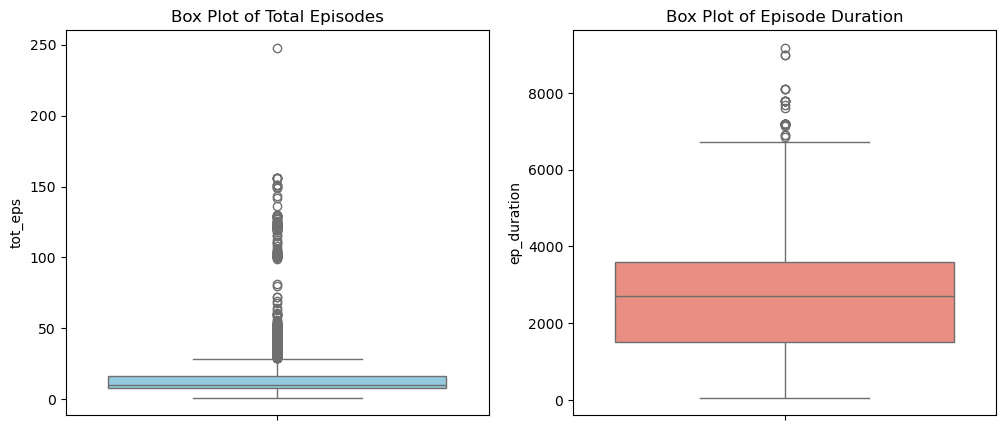

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Total Episodes
sns.boxplot(y=classification['tot_eps'], ax=axes[0], color='skyblue')
axes[0].set_title('Box Plot of Total Episodes')

# Plot Episode Duration
sns.boxplot(y=classification['ep_duration'], ax=axes[1], color='salmon')
axes[1].set_title('Box Plot of Episode Duration')

plt.show()

As observed in the box plots, the tot_eps variable contains several outliers, while ep_duration does not. Therefore, **StandardScaler** is applied to *tot_eps* to reduce the influence of extreme values, whereas **MinMaxScaler** is used for *ep_duration*.

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np

# Transform tot_eps

scaler = StandardScaler()

tot_eps = classification['tot_eps']

tot_eps_reshaped = np.array(tot_eps).reshape(-1,1) # Reshape tot_eps

classification['tot_eps'] = scaler.fit_transform(tot_eps_reshaped)

# Trasnform ep_duration

minmax = MinMaxScaler()

ep_duration = classification['ep_duration']

ep_duration_reshaped = np.array(ep_duration).reshape(-1,1) # Reshape ep_duration

classification['ep_duration'] = minmax.fit_transform(ep_duration_reshaped)

print(classification[['tot_eps', 'ep_duration']].describe())

            tot_eps  ep_duration
count  5.208000e+03  5208.000000
mean   3.274390e-17     0.279845
std    1.000096e+00     0.166093
min   -7.453534e-01     0.000000
25%   -3.739349e-01     0.157895
50%   -2.678154e-01     0.289474
75%    5.054331e-02     0.388158
max    1.236041e+01     1.000000


#### 2.4 Transform categorical data

The variables **genres**, **content_rt**, and **country** are stored as `object` data types. However, Weka’s Logistic Regression algorithm requires all input attributes to be **numerical or nominal with predefined categories**. Therefore, these variables must be transformed into a suitable representation while preserving as much information as possible.

#### 2.4.1 Transform the *genres* column

In [19]:
# Perform EDA on the columns

print("genres unique", classification['genres'].nunique())
print("content_rt unique", classification['content_rt'].nunique())
print("country unique", classification['country'].nunique())

print("Classification data:")
print(classification[['genres', 'content_rt', 'country']].head())

genres unique 1098
content_rt unique 6
country unique 3
Classification data:
                                     genres  \
0       Thriller,  Mystery,  Comedy,  Drama   
1                                    Sitcom   
2  Historical,  Romance,  Drama,  Melodrama   
3          Music,  Comedy,  Romance,  Youth   
4  Action,  Mystery,  Comedy,  Supernatural   

                              content_rt      country  
0  18+ Restricted (violence & profanity)  South Korea  
1                          Not Yet Rated  South Korea  
2                15+ - Teens 15 or older  South Korea  
3                          Not Yet Rated  South Korea  
4                15+ - Teens 15 or older  South Korea  


The **genres** attribute is a multi-label categorical variable, where each observation may belong to multiple genres simultaneously. Direct label encoding is not appropriate in this case, as it would impose an artificial ordinal relationship between genres.

To address this, the *genres* column is transformed using **multi-hot encoding**, where each unique genre is represented as a binary feature indicating its presence (1) or absence (0) for a given drama. This approach allows the Logistic Regression model to capture the contribution of individual genres without introducing unintended bias.

In [20]:
# Split the data

classification['genres'] = classification['genres'].fillna('').str.split(',')

print("classification['genres'] split: ", classification['genres'].head())

# Use the method explode to break each list into single data

classification_exploded = classification.explode('genres')
classification_exploded['genres'] = classification_exploded['genres'].str.strip()

print('Unique genres:', classification_exploded['genres'].unique())

classification['genres'] split:  0         [Thriller,   Mystery,   Comedy,   Drama]
1                                         [Sitcom]
2    [Historical,   Romance,   Drama,   Melodrama]
3            [Music,   Comedy,   Romance,   Youth]
4    [Action,   Mystery,   Comedy,   Supernatural]
Name: genres, dtype: object
Unique genres: ['Thriller' 'Mystery' 'Comedy' 'Drama' 'Sitcom' 'Historical' 'Romance'
 'Melodrama' 'Music' 'Youth' 'Action' 'Supernatural' 'Military' 'Fantasy'
 'Horror' 'Psychological' 'Life' 'Crime' 'Food' 'Adventure' 'Sci-Fi'
 'Business' 'Medical' 'Family' 'Political' 'Law' 'Mature' 'Sports'
 'Documentary' 'Martial Arts' 'Tokusatsu' 'War' 'Wuxia']


Once the unique genre values were identified and confirmed to be fewer than 50, the **MultiLabelBinarizer** class from the *scikit-learn* library was used to transform the *genres* attribute into multiple binary features. This approach efficiently represents multi-label categorical data while maintaining interpretability and avoiding the curse of excessive dimensionality.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb=MultiLabelBinarizer()

# Clean the genres data
classification['genres'] = classification['genres'].apply(lambda row_list: [str.strip(item) for item in row_list])

# Create the matrix to tranform the genders into numeric values
genre_matrix = mlb.fit_transform(classification['genres'])

# Create a dataframe that contains the columns of the matrix
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_, index=classification.index)
print("genre_df:")
print(genre_df.head())
print("genre_df: ", genre_df.columns)

# Join the matrix with the original dataframe
classification = classification.join(genre_df)

print("classification df:")
print(classification)
print("classification cols: ", classification.columns)

# Due to the transformation, the original genres column can be deleted

classification.drop(columns=['genres'], inplace=True)

genre_df:
   Action  Adventure  Business  Comedy  Crime  Documentary  Drama  Family  \
0       0          0         0       1      0            0      1       0   
1       0          0         0       0      0            0      0       0   
2       0          0         0       0      0            0      1       0   
3       0          0         0       1      0            0      0       0   
4       1          0         0       1      0            0      0       0   

   Fantasy  Food  ...  Romance  Sci-Fi  Sitcom  Sports  Supernatural  \
0        0     0  ...        0       0       0       0             0   
1        0     0  ...        0       0       1       0             0   
2        0     0  ...        1       0       0       0             0   
3        0     0  ...        1       0       0       0             0   
4        0     0  ...        0       0       0       0             1   

   Thriller  Tokusatsu  War  Wuxia  Youth  
0         1          0    0      0      0  
1     

#### 2.4.2 Transform country column

As observed during the initial exploratory analysis (Section 2.4.1), the *country* attribute contains three distinct categories: **South Korea**, **Japan**, and **Thailand**. To convert this categorical variable into a numerical format compatible with Weka’s Logistic Regression model, **one-hot encoding** was applied using the `get_dummies` method from the *pandas* library.

This transformation preserves the nominal nature of the variable while preventing the introduction of unintended ordinal relationships between countries.

In [22]:
# Create dummies
countries = pd.get_dummies(classification['country'])

# Join them with original dataframe

classification = classification.join(countries)

print("classification: ")
print(classification.head())
print("classification columns: ", classification.columns)

# Drop country column
classification.drop(columns=['country'], inplace=True)

classification: 
                                    drama_name   tot_eps  ep_duration  \
0                                    Mask Girl -0.426995     0.388158   
1                                Better Things -0.639234     0.098684   
2                                   My Dearest -0.267815     0.519737   
3                                Sing My Crush -0.373935     0.157895   
4  The Uncanny Counter Season 2: Counter Punch -0.161696     0.453947   

                              content_rt      country    dataset  \
0  18+ Restricted (violence & profanity)  South Korea  kor_drama   
1                          Not Yet Rated  South Korea  kor_drama   
2                15+ - Teens 15 or older  South Korea  kor_drama   
3                          Not Yet Rated  South Korea  kor_drama   
4                15+ - Teens 15 or older  South Korea  kor_drama   

  popularity_high_low  Action  Adventure  Business  ...  Sports  Supernatural  \
0                 Low       0          0         0  ..

#### 2.4.3 Transform content_rt column

The *content_rt* column represents an **ordinal categorical variable**, as its values follow a natural order based on audience age restrictions. To preserve this inherent ordering, the column was transformed using the **OrdinalEncoder** from the *scikit-learn* library.

This encoding approach ensures that the relative ordering between content ratings is maintained, while converting the variable into a numerical format compatible with Weka’s classification algorithms.

In [23]:
# Find the unique values
print("content_rt unique values")
print(classification['content_rt'].unique().tolist())


# Encode the data
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(categories=[['Not Yet Rated', 'G - All Ages', '13+ - Teens 13 or older',
                                      '15+ - Teens 15 or older', '18+ Restricted (violence & profanity)',
                                      'R - Restricted Screening (nudity & violence)']])

# Add the data to the original df

classification['content_rt_encoded'] = encoder.fit_transform(classification[['content_rt']])

print(classification[['content_rt', 'content_rt_encoded']].head())

classification.drop(columns=['content_rt'], inplace=True)

content_rt unique values
['18+ Restricted (violence & profanity)', 'Not Yet Rated', '15+ - Teens 15 or older', '13+ - Teens 13 or older', 'G - All Ages', 'R - Restricted Screening (nudity & violence)']
                              content_rt  content_rt_encoded
0  18+ Restricted (violence & profanity)                 4.0
1                          Not Yet Rated                 0.0
2                15+ - Teens 15 or older                 3.0
3                          Not Yet Rated                 0.0
4                15+ - Teens 15 or older                 3.0


#### 2.5 Save the dataframe and drop the unnecessary columns

In [24]:
print("classification cols: ", classification.columns)

print("classification:")
print(classification.head())

print("classification info:")
print(classification.info())

# Clean the country columns to match numeric data expected by Weka

countries_list = ['Japan', 'South Korea', 'Thailand']

for country in countries_list:
    classification[country] = pd.to_numeric(classification[country], errors='coerce').astype(int)

# Drop unnecessary cols

classification.drop(columns=['drama_name', 'dataset'], inplace=True)

# Save the df for Weka usage

classification.to_csv("classification_data.csv", index=False)

classification cols:  Index(['drama_name', 'tot_eps', 'ep_duration', 'dataset',
       'popularity_high_low', 'Action', 'Adventure', 'Business', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Food',
       'Historical', 'Horror', 'Law', 'Life', 'Martial Arts', 'Mature',
       'Medical', 'Melodrama', 'Military', 'Music', 'Mystery', 'Political',
       'Psychological', 'Romance', 'Sci-Fi', 'Sitcom', 'Sports',
       'Supernatural', 'Thriller', 'Tokusatsu', 'War', 'Wuxia', 'Youth',
       'Japan', 'South Korea', 'Thailand', 'content_rt_encoded'],
      dtype='object')
classification:
                                    drama_name   tot_eps  ep_duration  \
0                                    Mask Girl -0.426995     0.388158   
1                                Better Things -0.639234     0.098684   
2                                   My Dearest -0.267815     0.519737   
3                                Sing My Crush -0.373935     0.157895   
4  The Uncanny Counte